# 大作业：基于深度学习的细胞类型聚类
- 姓名：冯思程
- 学号：2112213
- 专业：计算机科学与技术

## 实验要求
### 截止日期：1月19号


### 数据集

实验数据：dataset1（无真实标签）、dataset2（有真实细胞类型标签）。

### 基本要求(20)：

使用简单的深度学习的方法对数据进行细胞类型聚类，得到多个亚群，完成实验报告（最好使用ipynb文件，包括但不限于代码、模型设计思路、模型架构图、聚类效果展示、实验分析等），并以csv文件提交最终的dataset1数据聚类结果（聚类编号从0到k，k为算法计算的k个潜在细胞群）。

### 中级要求(5)：

使用你的方法在dataset2上做实验，dataset2有真实的细胞类型标签，你可以对你的方法进行自我评估，并且分析结果，可以体现你的模型改进过程。展示你计算的Adjusted Rand Score指标。

### 高级要求(5): 
使用较为复杂的神经网络进行细胞类型聚类。如复现相关论文，用到你的网络中进行复现等。

### 加分项(5)：

基础要求的结果会通过Adjusted Rand Score指标进行评分，排名靠前会有额外得分。



=======================================================================================================================

# 开始

**环境**：python 3.10.9+vscode 1.82.2+一些必备的第三方库，例如numpy、torch等。

<span style="color:red">**注意**</span>：我在后文的代码都补充了适当的注释并在代码前进行了适当注释和分析，感谢学长学姐的批阅！辛苦！

## 完成情况说明

本次机器学习大作业，我根据要求，直接从复现论文开始，结合了**两篇论文**（后文具体说明）进行网络框架的构建和数据的聚类等等操作，规范合规的完成了基础+中级+高级部分的全部要求，感谢学长学姐的耐心批阅！提前这里祝学长学姐新年快乐！万事顺意！

我简单对我的实现脉络进行说明（经过向助教学长咨询认可）：首先先进行数据处理，然后结合两篇论文进行网络构建以及数据处理，然后在dataset2上根据ARI、NMI等参数进行优化架构，最后进行dataset1的聚类并输出结果，完成整个实验，下面我会具体地来说明我的实现过程。

## 基础要求部分+中级要求部分+高级要求部分结合


### 导入需要的包

In [10]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import warnings
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn import mixture
from sklearn.decomposition import FastICA
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score

### 数据读取

利用anndata库来进行数据读取，并简单去看一下数据维度和数据形式，便于我熟悉数据并进行进一步的处理。


In [11]:
# 用anndata库的方法读取数据
data = anndata.read_h5ad('dataset1.h5ad')
# print(data)
# print(data.X[:5])
data2 = anndata.read_h5ad('dataset2.h5ad')
# 记录一下dataset2的真实标签到列表中，用于后续的指标计算
true_labels_data2 = data2.obs['cell_type'].tolist()

### 数据预处理

这里利用scanpy库进行数据预处理。根据数据特点，我这里设计了预处理的流程，包括以下几点：
- 过滤掉少于一定阈值个数细胞中表达的基因（这里我选择的阈值是细胞个数的5%）
- 对表达数据进行自然对数转换，即加1后取自然对数，这个处理时为了标准化表达数据。
- 注意：这里我并没有调用scale方法去正态化，是因为加入正态化后网络的loss是大幅度增加，所以这里没有采用这个处理。

In [12]:
# 设置一下预处理部分的阈值，留下接口便于我后续进行调整，同时封装成函数方便后面对不同数据集测试
def preprocessing(data):
    filter_gene_threshold=data.X.shape[0]* 0.05 # 这个就可以大幅度降低维度了，所以这里我是参考了论文中的预处理阈值选择进行设定的，这个地方的阈值选择还会影响后面深度自编码器的训练速度。

    sc.pp.filter_genes(data, min_cells=filter_gene_threshold)
    sc.pp.log1p(data)
    return data

应用PCA+UAMP进行一下可视化，结果如下：（这里只是用于进行可视化，并不涉及网络搭建，所以可以看到这部分我用了data的一个副本showdata来进行，不会影响到源data）

这里是调用scanpy库来实现的

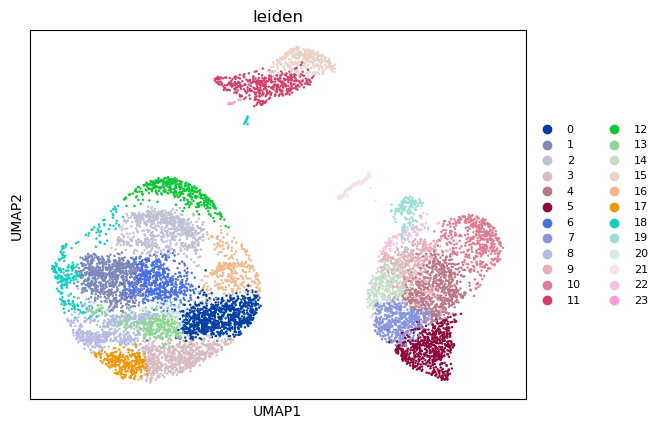

In [13]:
data = preprocessing(data)
# 这是dataset1的可视化
showdata=data
comps_threshold=30
leidencluster_threshold=1.5
sc.pp.pca(showdata, n_comps=comps_threshold, svd_solver='arpack')
sc.pp.neighbors(showdata, use_rep='X_pca')
sc.tl.umap(showdata)
sc.tl.leiden(showdata, resolution=leidencluster_threshold)
# 需要额外安装leidenalg库，绘制UMAP图
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    sc.pl.umap(showdata, color=["leiden"], legend_fontsize=8)

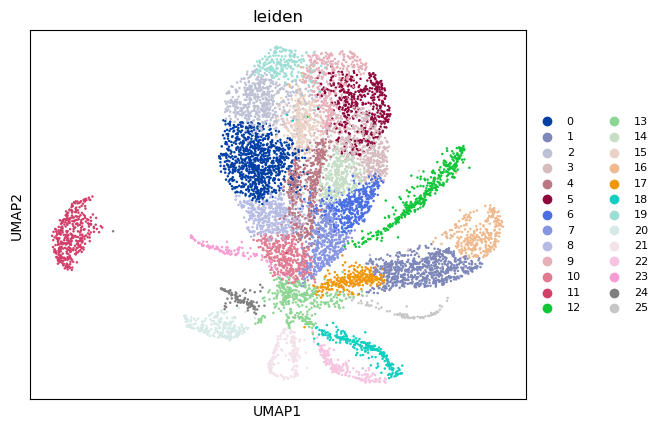

In [14]:
data2 = preprocessing(data2)
# 这是dataset2的可视化
showdata2=data2
comps_threshold=30
leidencluster_threshold=1.5
sc.pp.pca(showdata2, n_comps=comps_threshold, svd_solver='arpack')
sc.pp.neighbors(showdata2, use_rep='X_pca')
sc.tl.umap(showdata2)
sc.tl.leiden(showdata2, resolution=leidencluster_threshold)
# 需要额外安装leidenalg库，绘制UMAP图
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    sc.pl.umap(showdata2, color=["leiden"], legend_fontsize=8)

接下来进行论文的复现，经过查找资料我发现本次大作业的任务一般会采用自编码器进行实现，但是我觉得浅层的一个单调的自编码器并不能到达一个良好的聚类效果，于是我这里开始复现论文，这里我选择的论文是

**scGMAI: a Gaussian mixture model for clustering single-cell RNA-Seq data based on deep autoencoder**

你可以点击这个[链接](https://academic.oup.com/bib/article/22/4/bbaa316/6029147?login=true)来访问源论文，经过我对论文的仔细阅读和探究，下面我对模型设计思路和模型架构进行说明，并说明我的复现思路：

- 首先我要展示整个模型的pipeline架构图：

[![ba3aa76188e5078261ff9b14e431793.png](https://i.postimg.cc/jj01kYPk/ba3aa76188e5078261ff9b14e431793.png)](https://postimg.cc/gxs4n5Mv)

模型共分为四个processes，如下：
1. 数据预处理，这里需要进行基因过滤，筛选掉在细胞中表达很少的基因（上文中已经完成）
2. 深度自编码器网络进行数据重构，这是一种无监督的深度学习算法，用来从高维数据中学习到低维特征。另一方面在这种细胞的基因表达数据集中会存在大量的冗余和dropout事件，为了解决这个问题，自编码器同样可以进行数据重构，重建更良好的数据。本次实验根据论文中我进行了自编码器网络的**优化**，论文中是四层的自编码器架构，编码器有三个隐藏层层，解码器只有一层对应输出层。这里我优化为编码器仍为三个隐藏层，解码器有**两个隐藏层和一个对应输出层**。这里权重的初始化我选择了**Xavier 正态分布初始化器**，激活函数采用了**softplus函数**。同时我留下了几乎所有的参数接口，便于后续进行搜参进一步优化网络。
3. 利用FastICA进行降维，这是一种适用于高维、复杂且局部独立的数据进行特征提取的方法，其可以并行计算，大大减小时间成本，同时可以有效地提取独立且重要的特征便于下一步进行聚类。在论文中作者也讨论了这个算法在这里的应用优于其他的降维算法。
4. 利用GMM进行聚类，GMM是一种基于概率的模型，用于描述数据的不同子群体。它假设数据是由多个高斯分布混合而成的。GMM利用后验概率更准确地模拟数据分布，同时利用到EM算法处理初始聚类中心的敏感性、噪声等。这种聚类方法适用于本次实验的数据。

更加具体地的说明和讲解会在后文和注释中进一步展示。


<span style="color:red">网络**优化思路**说明：这里的主要考虑是解码与编码的对称性，原文中的非对称网络架构我认为会造成一定缺陷，但是可能是为了加速训练，但是我的训练过程并不缓慢，于是考虑对称性，我在解码器部分多加了两个隐藏层，初始化权重的方式是一致的，激活函数也利用softplus函数。<span>

同时训练过程是这样的：编写了一个抽取随机数据块的函数（get_random_block_from_data）用来进行每轮的训练。同时训练采用mini-batch方法进行训练。参数留下接口便于后续使用。这里我将batchsize初始设定为**数据量-1**，这是为了loss的稳定性而设定，在后续的进一步优化过程中我会进行调整来观察效果。同时我将训练流程封装成函数便于后续调用。提升代码规范性和清晰度。

然后为了完善我的网络架构，我又结合了另一篇论文

**Clustering single-cell RNA-seq data with a model-based deep learning approach**

你可以点击这个[链接](https://www.nature.com/articles/s42256-019-0037-0e)来访问源论文，经过我对论文的仔细阅读和探究，下面我在上文的网络架构基础上进行修改部分的说明：

其中最主要的更改就是在encoder部分的每层加入了一个高斯噪声，这一点是根据该篇论文中的网络架构来修改的，其中标准差参数我定为0.1，这个参数的确定也是经过我的调试来确定的。其他就是对网络构建的一些微调，不再赘述了，可以看源码。

然后其实两篇论文在自编码器的网络构建上其实是非常相似的，下图是该篇论文中的自编码器架构图：

[![8d576d173b3da70407798bddf4004ab.png](https://i.postimg.cc/ZY8QQDxC/8d576d173b3da70407798bddf4004ab.png)](https://postimg.cc/hhGMzswB)



In [15]:
from tensorflow.keras.layers import GaussianNoise
# 建立自编码器模型
class Autoencoder(Model):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_hidden3,noise_sd=0.1):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            Input(shape=(n_input,)),
            GaussianNoise(noise_sd),  # 加入高斯噪声
            Dense(n_hidden1, activation='softplus', kernel_initializer=tf.keras.initializers.GlorotNormal()),
            GaussianNoise(noise_sd),  # 加入高斯噪声
            Dense(n_hidden2, activation='softplus', kernel_initializer=tf.keras.initializers.GlorotNormal()),
            GaussianNoise(noise_sd),  # 加入高斯噪声
            Dense(n_hidden3, activation='softplus', kernel_initializer=tf.keras.initializers.GlorotNormal())
        ])

        self.decoder = tf.keras.Sequential([
            # 优化了网络结构，加了两个隐藏层
            Dense(n_hidden2, activation='softplus', kernel_initializer=tf.keras.initializers.GlorotNormal()),
            Dense(n_hidden1, activation='softplus', kernel_initializer=tf.keras.initializers.GlorotNormal()),
            Dense(n_input, activation=None, kernel_initializer=tf.keras.initializers.GlorotNormal())
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 随机抽取数据块
def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, data.shape[0] - batch_size)
    return data[start_index:(start_index + batch_size)]


# 封装的训练和重构函数
def train_and_reconstruct_autoencoder(data, n_hidden1=800, n_hidden2=400, n_hidden3=800, training_epochs=100, display_step=1,learningrate=0.001):
    n_input = data.shape[1]  # 数据特征数
    batch_size = data.shape[0] - 1  # 可调整的批量大小

    # 实例化自编码器
    autoencoder = Autoencoder(n_input, n_hidden1, n_hidden2, n_hidden3)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learningrate), loss='mean_squared_error')

    # 训练自编码器
    for epoch in range(training_epochs):
        total_batch = int(data.shape[0] / batch_size)
        for i in range(total_batch):
            batch_xs = get_random_block_from_data(data, batch_size)
            loss = autoencoder.train_on_batch(batch_xs, batch_xs)
        # 每epoch输出loss结果
        if epoch % display_step == 0:
            print("Epoch:", '%d,' % (epoch + 1), "Loss:", "{:.9f}".format(loss))

    # 使用训练好的自编码器进行变换和重构
    encoded_data = autoencoder.encoder(data).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    return decoded_data# 返回重构数据

高维特征进行降维，这里首选是论文原文的FastICA（快速独立成分分析）方法。使用固定点迭代方案来最大化非高斯性，速度更快。降维同样封装成函数便于后续调用


In [16]:
# 参数含义：n_components: 这个参数指定了降维后保留的特征数量；whiten: 白化是一个预处理步骤，目的是使得每个特征具有相同的方差。
def perform_fast_ica(data, n_components=30, whiten='arbitrary-variance', max_iter=1000, tol=0.001):
    transformer = FastICA(n_components=n_components, whiten=whiten, max_iter=max_iter, tol=tol)
    X_reduction = transformer.fit_transform(data)
    return X_reduction

利用GMM进行聚类，迭代不同数量的聚类数量来找出最低BIC值的GMM模型并返回聚类结果，BIC值是贝叶斯信息准则值。

In [17]:
# 参数含义：max_components：最大聚类数量
def gaussian_mixture_clustering(X, max_components=30):
    lowest_bic = np.infty
    bic = []
    best_gmm = None

    for n_components in range(15, max_components):
        
        gmm = mixture.GaussianMixture(n_components=n_components)
        gmm.fit(X)
        bic.append(gmm.bic(X))

        
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

    
    pred_labels = best_gmm.predict(X) if best_gmm else None

    return pred_labels

评价指标，这里利用ARI、NMI、Homogeneity、Completeness作为评价聚类结果的指标。

我均将这四个指标封装成函数便于后续调用。

In [18]:
def calculate_adjusted_rand_index(true_labels, predicted_labels):
    
    rand_index = adjusted_rand_score(true_labels, predicted_labels)
    return rand_index

def calculate_nmi(true_labels, predicted_labels):

    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    return nmi

def calculate_homogeneity(true_labels, predicted_labels):

    homogeneity = homogeneity_score(true_labels, predicted_labels)
    return homogeneity

def calculate_completeness(true_labels, predicted_labels):

    completeness = completeness_score(true_labels, predicted_labels)
    return completeness



In [19]:
# 在dataset2上进行测试流程，由于我在上文中将大多数子流程都封装成了函数，我这里仅需要进行调用即可
data2_reformed = train_and_reconstruct_autoencoder(data2.X.toarray(), n_hidden1=800, n_hidden2=400, n_hidden3=800, training_epochs=1000, display_step=50, learningrate=0.001)

Epoch: 1, Loss: 0.338402331
Epoch: 51, Loss: 0.077357717
Epoch: 101, Loss: 0.076696396
Epoch: 151, Loss: 0.076465584
Epoch: 201, Loss: 0.076384701
Epoch: 251, Loss: 0.076298878
Epoch: 301, Loss: 0.075822897
Epoch: 351, Loss: 0.075580202
Epoch: 401, Loss: 0.074637413
Epoch: 451, Loss: 0.073930800
Epoch: 501, Loss: 0.073834807
Epoch: 551, Loss: 0.073490590
Epoch: 601, Loss: 0.073406786
Epoch: 651, Loss: 0.073301584
Epoch: 701, Loss: 0.073831499
Epoch: 751, Loss: 0.072341613
Epoch: 801, Loss: 0.072159216
Epoch: 851, Loss: 0.071970522
Epoch: 901, Loss: 0.071721002
Epoch: 951, Loss: 0.071580507


In [ ]:
data2_reformed_afterica = perform_fast_ica(data2_reformed, n_components=15, whiten='arbitrary-variance', max_iter=10000, tol=0.0001)

pre_labels_data2=gaussian_mixture_clustering(data2_reformed_afterica, max_components=30)

In [ ]:
print("预测聚类结果的类别数量：",len(set(pre_labels_data2))) # 查看一下聚类结果的类别数量
print("真实聚类的类别数量：",len(set(true_labels_data2)))

预测聚类结果的类别数量： 15
真实聚类的类别数量： 22


In [ ]:
# 评价一下聚类效果
randindex=calculate_adjusted_rand_index(true_labels_data2, pre_labels_data2)
nmiindex=calculate_nmi(true_labels_data2, pre_labels_data2)
homogeneityindex=calculate_homogeneity(true_labels_data2, pre_labels_data2)
completenessindex=calculate_completeness(true_labels_data2, pre_labels_data2)

print("Adjusted Rand Index:", randindex)
print("Normalized Mutual Information:", nmiindex)
print("Homogeneity:", homogeneityindex)
print("Completeness:", completenessindex)

Adjusted Rand Index: 0.4591886813234308
Normalized Mutual Information: 0.5884955466971381
Homogeneity: 0.5992694862159388
Completeness: 0.5781021629481663


可以看到ARI基本每次都会超过0.45，NMI约为0.6，已经接近源论文中的数据，说明复现成功。

## 进一步优化



#### 模型优化

上文已经说明针对网络结构的优化，所以在网络结构方面我不打算做进一步优化（这是出于如果隐藏层过多会导致训练过慢，过少会让重构效果变差的考虑）

#### 调参

下面我要进一步进行优化，首先是调参，这里由于一次自编码器的训练时间大概需要20min+，所以这里我的调参分为前后端。

首先进行前端的调参，经过我的观察，发现前端的几个关键性的参数包括：
- 学习率
- batchsize大小
- epoch次数
- 编码器端的三层隐藏层的神经元数量
- 预处理阶段进行基因过滤的阈值

这里由于是每个epoch随机选取数据块，为了避免loss的波动性，这里将batchsize设置为数据行数量-1，这个保持不变。

神经元数量，这里我参考源论文中的参数进行设置。（因为想去搜寻这个时间成本过高，而且意义不大）

通过多次观察，我发现这里的迭代虽然看起来每次loss会有波动，而且看起来好像是收敛了，但是实际上总体趋势一直在下降。

对于这个预处理阶段进行基因过滤的阈值，我觉得或许会对模型的效果造成一定的影响，所以这里我首先会选取这个参数进行调整。

<span style="color:red">**注意**</span>：由于这里每次训练时间太长，而且输出不是非常稳定，我没有选择网格搜索法来进行参数调整，而且自行修改参数进行多次测试。这里由于篇幅问题我并没有将每次的测试结果都展示出来，而是直接在上文的调用中调整参数。最后看到的结果即是表现效果最良好、稳定的参数。



然后我来调整后端的参数，后端的主要参数是用到FastICA的保留独立成分个数和聚类的最大聚类数量限定。但是可以知道聚类的最大聚类数量限定是无需调整的，因为我的聚类函数会自动去测评从15个聚类数量到最大数量的所有聚类选择效果最好的那个。那么下面编写代码对于同一份重构后的数据利用网格搜索法针对FastICA的保留独立成分个数进行搜索。

注意：这里为了保证输出的稳定我进行了重复测试，重复三次取平均值进行比较。可以看到这里找到最大的ARI都是接近<span style="color:red">**0.5**<span>的

In [ ]:
ARImax = 0
ncomponentmax = 0

for i in range(15):
    data2_reformed_afterica = perform_fast_ica(data2_reformed, n_components=i+1, whiten='arbitrary-variance', max_iter=10000, tol=0.0001)
    total_randindex = 0
    for _ in range(3):  # 重复计算三次
        pre_labels_data2 = gaussian_mixture_clustering(data2_reformed_afterica, max_components=30)
        randindex = calculate_adjusted_rand_index(true_labels_data2, pre_labels_data2)
        total_randindex += randindex
    avg_randindex = total_randindex / 3  # 计算平均值
    print(avg_randindex)
    if avg_randindex > ARImax:
        ARImax = avg_randindex
        ncomponentmax = i+1

print("最佳ARI：", ARImax)
print("对应的最佳保留独立成分个数：", ncomponentmax)

0.02265611985846824
0.158522002296575
0.29197882886366594
0.3745938474824235
0.4146135295611281
0.3926121488366387
0.4070321056411393
0.40459394445587843
0.4267183255613391
0.44923231374360656
0.41964549097071857
0.41029319873772324
0.4263000668193912
0.4361922691056825
0.4677138357585812
最佳ARI： 0.4677138357585812
对应的最佳保留独立成分个数： 15


然后我要对模型的组件开始更换对比聚类效果，我想的是最好可以训练出一个可以根据数据集特点进行自适应选取聚类组件的模型

这里可以进行调整的组件主要有两种：
- 降维方法
- 聚类方法

In [6]:
# 下面先实现一些对应的组件
import nimfa
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

# 首先实现降维组件
def pca_reduction(X, n_components=5):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(X)


def umap_reduction(X):
    reducer = umap.UMAP()
    return reducer.fit_transform(X)


def tsne_reduction(X):
    tsne = TSNE()
    return tsne.fit_transform(X)


# 然后实现聚类组件
def kmeans_clustering(X_reduction, max_clusters):
    best_score = -1
    best_labels = None

    for n_clusters in range(15, max_clusters + 1):
        clustering = KMeans(n_clusters=n_clusters, n_init=10).fit(X_reduction)
        labels = clustering.predict(X_reduction)
        score = silhouette_score(X_reduction, labels)

        if score > best_score:
            best_score = score
            best_labels = labels

    return best_labels

def spectral_clustering(X_reduction, max_clusters):
    best_score = -1
    best_labels = None

    for n_clusters in range(15, max_clusters):
        clustering = SpectralClustering(n_clusters=n_clusters).fit(X_reduction)
        labels = clustering.labels_
        score = silhouette_score(X_reduction, labels)

        if score > best_score:
            best_score = score
            best_labels = labels

    return best_labels

def evaluate_combinations(X, true_labels, max_clusters):
    # 定义降维方法列表
    dimension_reduction_methods = {
        'PCA': pca_reduction,
        'UMAP': umap_reduction,
        't-SNE': tsne_reduction
    }

    # 定义聚类方法列表
    clustering_methods = {
        'KMeans': kmeans_clustering,
        'SpectralClustering': spectral_clustering
    }

    # 遍历所有降维和聚类方法的组合
    for dr_name, dr_method in dimension_reduction_methods.items():
        # 应用降维方法
        X_reduced = dr_method(X)

        for cl_name, cl_method in clustering_methods.items():
            # 应用聚类方法
            predicted_labels = cl_method(X_reduced, max_clusters)

            # 计算并输出调整后的随机指数
            ari_score = calculate_adjusted_rand_index(true_labels, predicted_labels)
            print(f"组合: {dr_name} - {cl_name}, ARI得分: {ari_score}")


In [22]:
evaluate_combinations(data2_reformed, true_labels_data2, 25)

组合: PCA - KMeans, ARI得分: 0.1864995772179382
组合: PCA - SpectralClustering, ARI得分: 0.0068374274866264875
组合: UMAP - KMeans, ARI得分: 0.2976978623790681
组合: UMAP - SpectralClustering, ARI得分: 0.30011233157508926


观察结果可知，实际上这个组件针对这个数据集并不需要更换，源模型的组件搭配已经是最好的了。这也侧面验证了论文，因为作者是一定也进行了多种组合的测试的

## 预测dataset1的结果

这里会应用上文已经调整好的参数进行针对dataset1的预测，并将其存到csv中

In [19]:
data_reformed = train_and_reconstruct_autoencoder(data.X.toarray(), n_hidden1=800, n_hidden2=400, n_hidden3=800, training_epochs=1000, display_step=50, learningrate=0.001)

Epoch: 1, Loss: 0.368473202
Epoch: 51, Loss: 0.110028803
Epoch: 101, Loss: 0.107222408
Epoch: 151, Loss: 0.105855443
Epoch: 201, Loss: 0.103464037
Epoch: 251, Loss: 0.103448205
Epoch: 301, Loss: 0.101724654
Epoch: 351, Loss: 0.101248160
Epoch: 401, Loss: 0.100966163
Epoch: 451, Loss: 0.100414291
Epoch: 501, Loss: 0.100059777
Epoch: 551, Loss: 0.099831931
Epoch: 601, Loss: 0.099866778
Epoch: 651, Loss: 0.099365860
Epoch: 701, Loss: 0.099369064
Epoch: 751, Loss: 0.099049971
Epoch: 801, Loss: 0.098771393
Epoch: 851, Loss: 0.098472409
Epoch: 901, Loss: 0.098169349
Epoch: 951, Loss: 0.097995840


In [ ]:
data_reformed_afterica = perform_fast_ica(data_reformed, n_components=15, whiten='arbitrary-variance', max_iter=10000, tol=0.0001)
pre_labels_data=gaussian_mixture_clustering(data_reformed_afterica, max_components=26) 

下面进行文件写入，利用csv库

In [ ]:
import csv

filename = "prelabel_fordataset1.csv"

with open(filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    for label in pre_labels_data:
        writer.writerow([label])

print(f"Labels successfully written to {filename}")

Labels successfully written to prelabel_fordataset1.csv
